In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.draw import line, circle_perimeter, line_aa
from skimage.feature import canny
import copy
from math import atan2
from skimage.transform import resize
from image_transformations import *
from time import time

In [2]:
def plot_grayscale_pic(picture, fig_width=7, fig_length=7):
    plt.figure(figsize=(fig_width,fig_length))
    plt.imshow(picture, cmap=plt.get_cmap("gray"), vmin=0.0, vmax=1.0)
    plt.show()
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

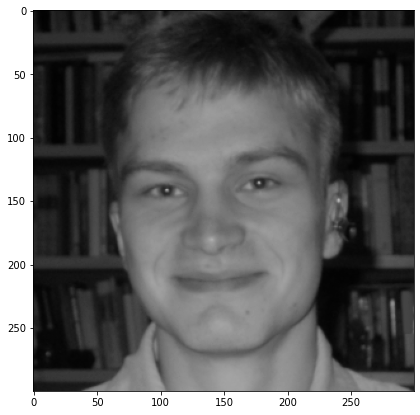

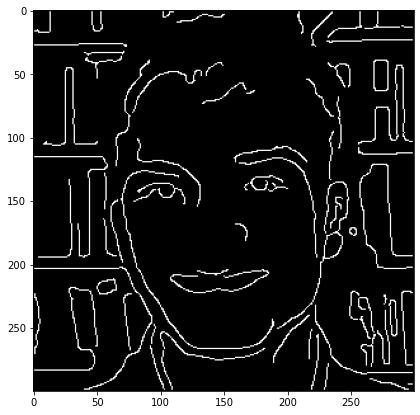

In [31]:
LONG_SIDE = 300

img = mpimg.imread("t2.png")
img = largest_square(img)
img = resize(img, (LONG_SIDE, LONG_SIDE))

orig_pic = rgb2gray(img)

edges = canny(orig_pic, sigma=2)
# orig_pic[edges] = 0.3
orig_pic = orig_pic*0.9

plot_grayscale_pic(orig_pic)
plot_grayscale_pic(edges)

In [32]:
orig_pic[0][:5]

array([0.10298425, 0.08007733, 0.05670787, 0.03847192, 0.02867264])

In [33]:
def create_rectangle_nail_positions(picture, nail_step=2):
    height = len(picture)
    width = len(picture[0])
    
    nails_top = [(0, i) for i in range(0, width, nail_step)]
    nails_bot = [(height-1, i) for i in range(0, width, nail_step)]
    nails_right = [(i, width-1) for i in range(1, height-1, nail_step)]
    nails_left = [(i, 0) for i in range(1, height-1, nail_step)]
    nails = nails_top + nails_right + nails_bot + nails_left
    
    return nails

def create_circle_nail_positions(picture, nail_step=2):
    height = len(picture)
    width = len(picture[0])
    
    centre = (height // 2, width // 2)
    radius = min(height, width) // 2 - 1
    rr, cc = circle_perimeter(centre[0], centre[1], radius)
    nails = list(set([(rr[i], cc[i]) for i in range(len(cc))]))
    nails.sort(key=lambda c: atan2(c[0] - centre[0], c[1] - centre[1]))
    nails = nails[::nail_step]
    
    return nails

def init_black_canvas(picture):
    height = len(picture)
    width = len(picture[0])
    return np.zeros((height, width))

def init_white_canvas(picture):
    height = len(picture)
    width = len(picture[0])
    return np.ones((height, width))

In [34]:
def get_aa_line(from_pos, to_pos, str_strength, picture):
    rr, cc, val = line_aa(from_pos[0], from_pos[1], to_pos[0], to_pos[1])
    line = picture[rr, cc] + str_strength * val
    line = np.clip(line, a_min=0, a_max=1)
    
    return line, rr, cc

def find_best_nail_position(current_position, nails, str_pic, orig_pic, str_strength):

    best_cumulative_improvement = -99999
    best_nail_position = None

    for nail_position in nails:

        overlayed_line, rr, cc = get_aa_line(current_position, nail_position, str_strength, str_pic)

        before_overlayed_line_diff = np.abs(str_pic[rr, cc] - orig_pic[rr, cc])**2
        after_overlayed_line_diff = np.abs(overlayed_line - orig_pic[rr, cc])**2

        cumulative_improvement =  np.sum(before_overlayed_line_diff - after_overlayed_line_diff)

        if cumulative_improvement >= best_cumulative_improvement:
            best_cumulative_improvement = cumulative_improvement
            best_nail_position = nail_position

    return best_nail_position, best_cumulative_improvement

In [35]:
def create_art(nails, orig_pic, str_pic, str_strength):
    
    start = time()
    iter_times = []
    
    current_position = nails[0]

    i = 0
    while True:
        start_iter = time()
        
        i += 1
        if i > 2500:
            break
        if i % 200 == 0:
            plot_grayscale_pic(str_pic)
        
        best_nail_position, best_cumulative_improvement = find_best_nail_position(current_position, nails,
                                                                                  str_pic, orig_pic, str_strength)

        best_overlayed_line, rr, cc = get_aa_line(current_position, best_nail_position, str_strength, str_pic)
        str_pic[rr, cc] = best_overlayed_line
        
        current_position = best_nail_position
        iter_times.append(time() - start_iter)

    print(f"Time: {time() - start}")
    print(f"Avg iteration time: {np.mean(iter_times)}")

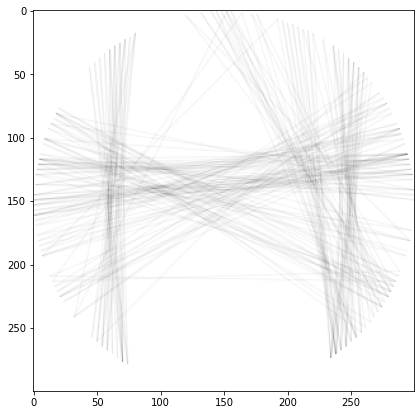

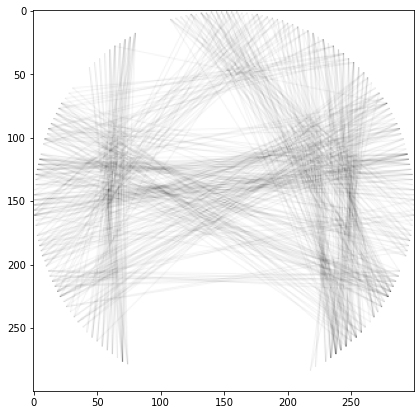

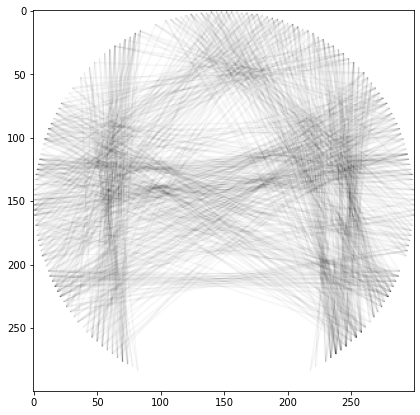

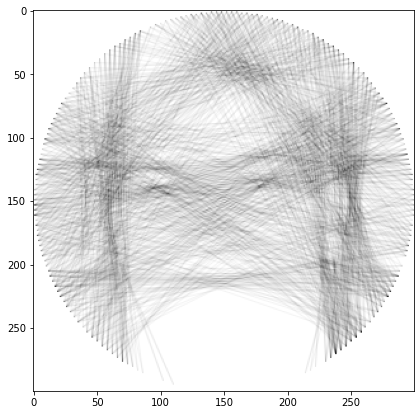

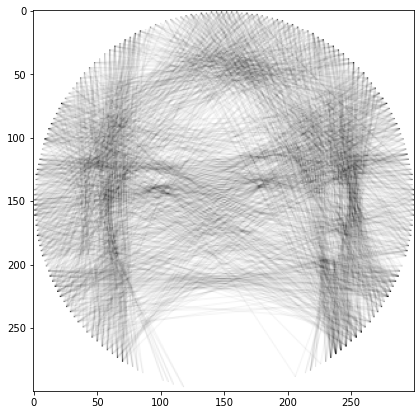

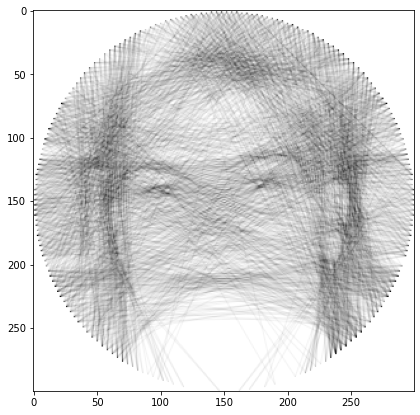

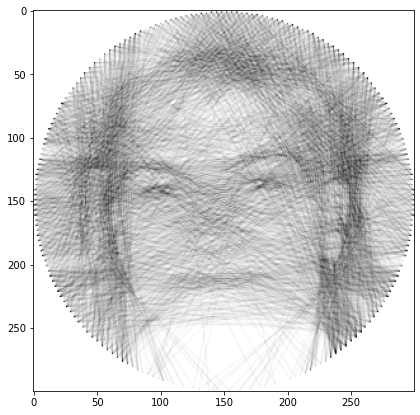

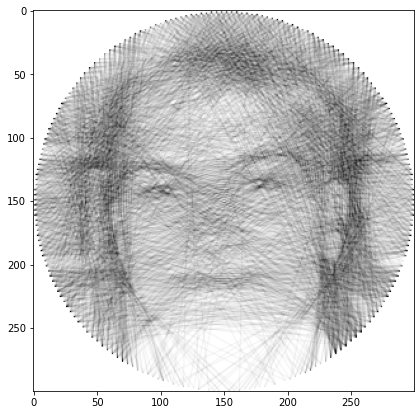

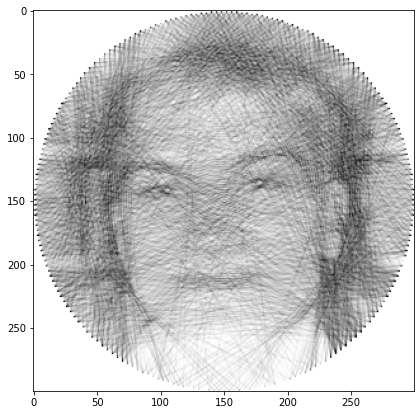

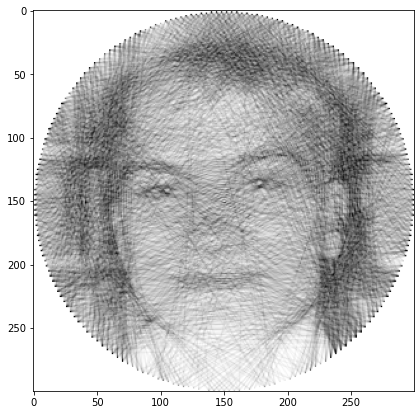

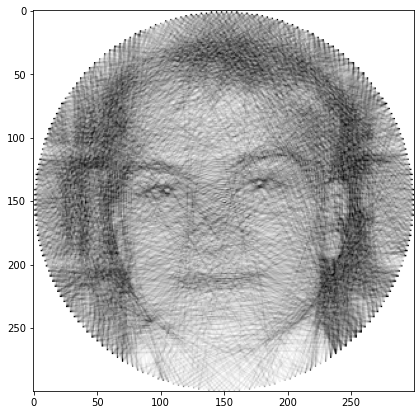

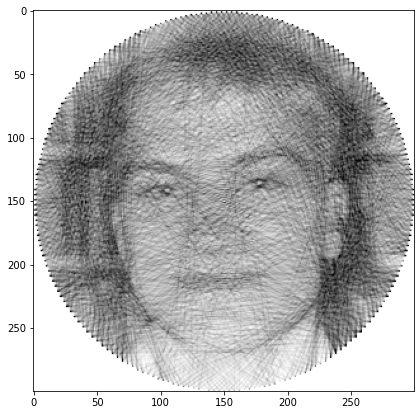

Time: 71.89424133300781
Avg iteration time: 0.028756496238708497


In [36]:
nails = create_circle_nail_positions(orig_pic, 4)
str_pic = init_white_canvas(orig_pic)
create_art(nails, orig_pic, str_pic, -0.05)

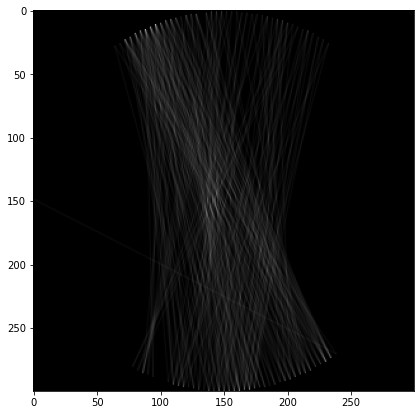

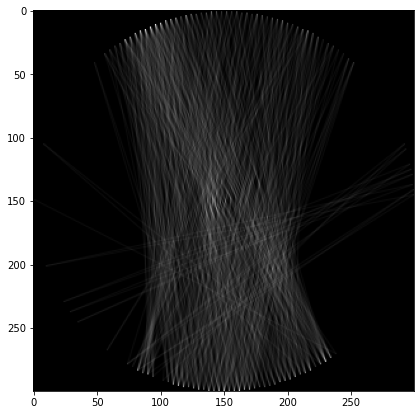

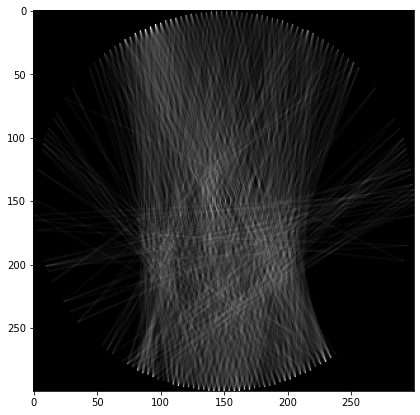

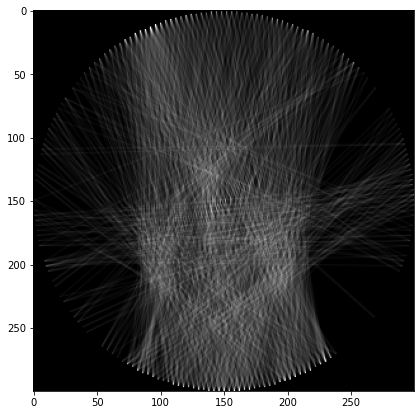

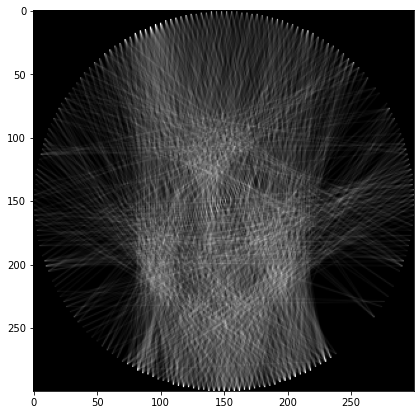

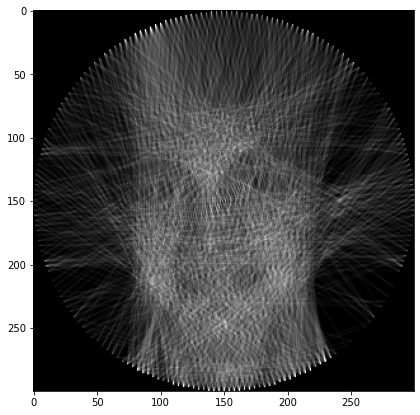

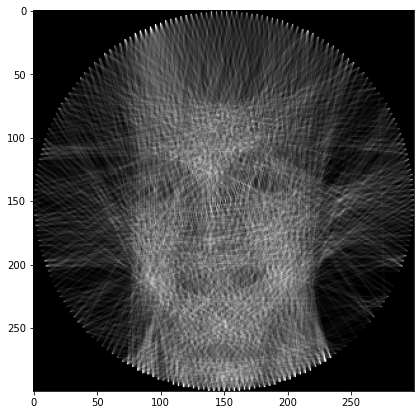

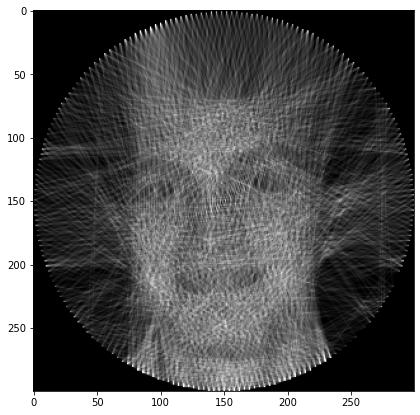

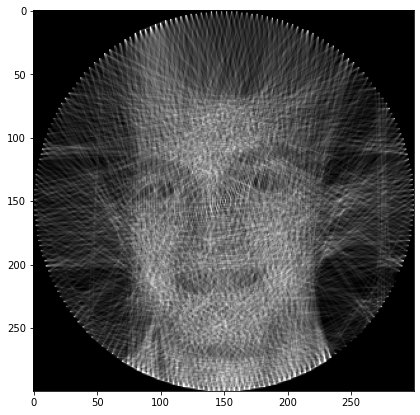

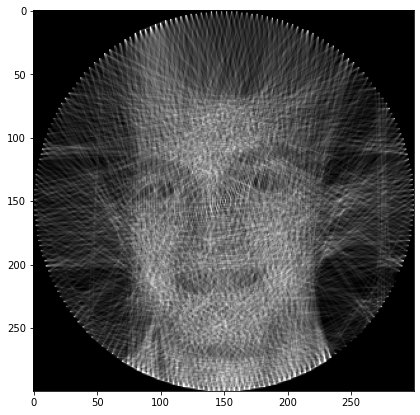

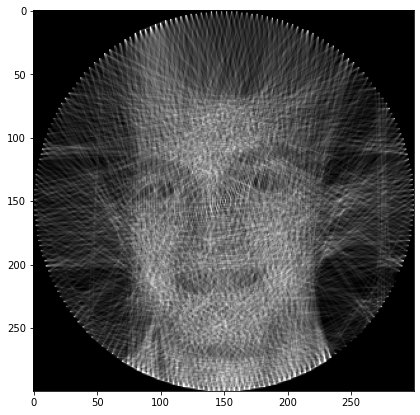

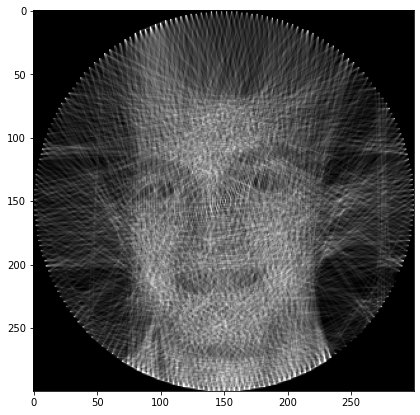

Time: 70.45041680335999
Avg iteration time: 0.028179366397857664


In [37]:
nails = create_circle_nail_positions(orig_pic, 4)
str_pic = init_black_canvas(orig_pic)
create_art(nails, orig_pic, str_pic, 0.05)